# Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error, mean_absolute_error
import joblib
import os

In [2]:
data = pd.read_csv('C:/Users/IreOluwa/Documents/projects/Pharma-Data/Data/pharma-data.csv')
df = pd.DataFrame(data)

#### Data Check

In [3]:
df.head()

,Distributor,Customer Name,City,Country,Latitude,Longitude,Channel,Sub-channel,Product Name,Product Class,Quantity,Price,Sales,Month,Year,Name of Sales Rep,Manager,Sales Team
0,Gottlieb-Cruickshank,"Zieme, Doyle and Kunze",Lublin,Poland,51.2333,22.5667,Hospital,Private,Topipizole,Mood Stabilizers,4.0,368,1472.0,January,2018,Mary Gerrard,Britanny Bold,Delta
1,Gottlieb-Cruickshank,Feest PLC,Świecie,Poland,53.4167,18.4333,Pharmacy,Retail,Choriotrisin,Antibiotics,7.0,591,4137.0,January,2018,Jessica Smith,Britanny Bold,Delta
2,Gottlieb-Cruickshank,Medhurst-Beer Pharmaceutical Limited,Rybnik,Poland,50.0833,18.5000,Pharmacy,Institution,Acantaine,Antibiotics,30.0,66,1980.0,January,2018,Steve Pepple,Tracy Banks,Bravo
3,Gottlieb-Cruickshank,Barton Ltd Pharma Plc,Czeladź,Poland,50.3333,19.0833,Hospital,Private,Lioletine Refliruvax,Analgesics,6.0,435,2610.0,January,2018,Mary Gerrard,Britanny Bold,Delta
4,Gottlieb-Cruickshank,Keeling LLC Pharmacy,Olsztyn,Poland,53.7800,20.4942,Pharmacy,Retail,Oxymotroban Fexoformin,Analgesics,20.0,458,9160.0,January,2018,Anne Wu,Britanny Bold,Delta


In [4]:
df.describe()

,Latitude,Longitude,Quantity,Price,Sales,Year
count,254082.000000,254082.000000,254082.000000,254082.000000,2.540820e+05,254082.000000
mean,50.962222,10.803212,112.872139,412.207720,4.643772e+04,2018.385187
std,1.625526,4.143311,744.310385,224.963687,3.491918e+05,1.041352
min,47.514200,6.083800,-7200.000000,22.000000,-4.161600e+06,2017.000000
25%,49.805600,7.891100,5.000000,195.000000,1.704000e+03,2018.000000
50%,51.133300,9.397800,20.000000,430.000000,5.850000e+03,2018.000000
75%,52.083300,12.133300,50.000000,605.000000,2.156525e+04,2019.000000
max,54.781900,23.566700,117600.000000,794.000000,7.420560e+07,2020.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254082 entries, 0 to 254081
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Distributor        254082 non-null  object 
 1   Customer Name      254082 non-null  object 
 2   City               254082 non-null  object 
 3   Country            254082 non-null  object 
 4   Latitude           254082 non-null  float64
 5   Longitude          254082 non-null  float64
 6   Channel            254082 non-null  object 
 7   Sub-channel        254082 non-null  object 
 8   Product Name       254082 non-null  object 
 9   Product Class      254082 non-null  object 
 10  Quantity           254082 non-null  float64
 11  Price              254082 non-null  int64  
 12  Sales              254082 non-null  float64
 13  Month              254082 non-null  object 
 14  Year               254082 non-null  int64  
 15  Name of Sales Rep  254082 non-null  object 
 16  Ma

## Data Cleaning

### Data fix - Getting rid of unwanted values

In [6]:
df['Quantity'] = df['Quantity'].abs()
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')

In [7]:
df['Sales'] = df['Sales'].abs()
df['Sales'] = pd.to_numeric(df['Sales'], errors='coerce')

In [8]:
df['Customer Name'].value_counts()

Customer Name
Spinka, Schowalter and Conn                   440
Fritsch, Hodkiewicz and Sipes Pharma Plc      437
Weber Ltd Pharmaceutical Ltd                  436
Corkery-Kovacek Pharm                         436
Nolan, DuBuque and Schultz                    434
                                             ... 
Fadel-West                                    172
Wiegand, Jast and Yost Pharma Plc             164
Bernier, Murphy and Rau Pharmaceutical Ltd    164
Schaefer-Rolfson                              162
Medhurst-Beer Pharmaceutical Limited          157
Name: count, Length: 751, dtype: int64

### Data Type Fix

In [9]:
df['Quantity'] = df['Quantity'].abs().astype(float)
df['Sales'] = df['Sales'].abs().astype(float)
df['Price'] = df['Price'].astype(float)

### Duplicate Check

In [10]:
print("Duplicate Rows:", df.duplicated().sum())

Duplicate Rows: 4


In [11]:
df.drop_duplicates(inplace=True)

### Outlier Check

In [12]:
def find_anomalies(df):
    anomalies = []
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    for outlier in df:
        if outlier > upper_limit or outlier < lower_limit:
            anomalies.append(outlier)
    return anomalies

#### Sales Outlier Fix

In [13]:
sales_outlier = find_anomalies(df['Sales'])
df = df[~df['Sales'].isin(sales_outlier)]
len(sales_outlier)

35151

#### Quantity Outlier Fix

In [14]:
quantity_outlier = find_anomalies(df['Sales'])
df = df[~df['Quantity'].isin(quantity_outlier)]
len(quantity_outlier)

18912

In [15]:
print(f"Data after outlier removal: {df.shape}")

Data after outlier removal: (218927, 18)


<Axes: >

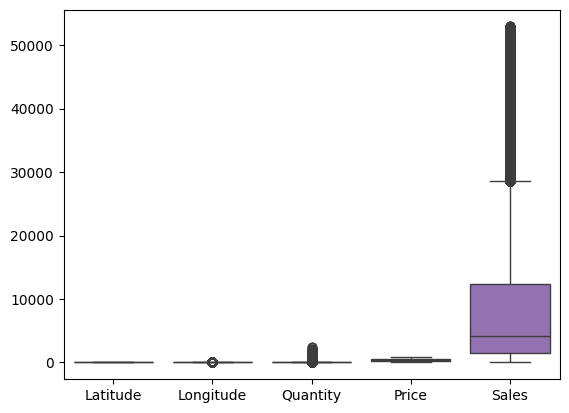

In [16]:
numerical_cols = df.select_dtypes('float64')
sns.boxplot(numerical_cols)

In [17]:
df.to_csv('cleaned_pharma_data.csv', index=False)

In [18]:
df.head()

,Distributor,Customer Name,City,Country,Latitude,Longitude,Channel,Sub-channel,Product Name,Product Class,Quantity,Price,Sales,Month,Year,Name of Sales Rep,Manager,Sales Team
0,Gottlieb-Cruickshank,"Zieme, Doyle and Kunze",Lublin,Poland,51.2333,22.5667,Hospital,Private,Topipizole,Mood Stabilizers,4.0,368.0,1472.0,January,2018,Mary Gerrard,Britanny Bold,Delta
1,Gottlieb-Cruickshank,Feest PLC,Świecie,Poland,53.4167,18.4333,Pharmacy,Retail,Choriotrisin,Antibiotics,7.0,591.0,4137.0,January,2018,Jessica Smith,Britanny Bold,Delta
2,Gottlieb-Cruickshank,Medhurst-Beer Pharmaceutical Limited,Rybnik,Poland,50.0833,18.5000,Pharmacy,Institution,Acantaine,Antibiotics,30.0,66.0,1980.0,January,2018,Steve Pepple,Tracy Banks,Bravo
3,Gottlieb-Cruickshank,Barton Ltd Pharma Plc,Czeladź,Poland,50.3333,19.0833,Hospital,Private,Lioletine Refliruvax,Analgesics,6.0,435.0,2610.0,January,2018,Mary Gerrard,Britanny Bold,Delta
4,Gottlieb-Cruickshank,Keeling LLC Pharmacy,Olsztyn,Poland,53.7800,20.4942,Pharmacy,Retail,Oxymotroban Fexoformin,Analgesics,20.0,458.0,9160.0,January,2018,Anne Wu,Britanny Bold,Delta


## Exploratory Data Analysis (EDA)

### Correlation

In [19]:
cols = df[['Quantity', 'Price', 'Sales', 'Year']]
cols.corr()

,Quantity,Price,Sales,Year
Quantity,1.000000,-0.216700,0.509558,0.009509
Price,-0.216700,1.000000,0.254648,0.000293
Sales,0.509558,0.254648,1.000000,0.007324
Year,0.009509,0.000293,0.007324,1.000000


#### HeatMap

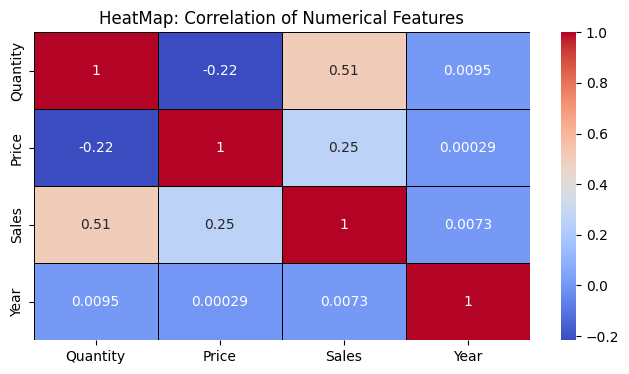

In [20]:
numeric_cols = ['Quantity', 'Price', 'Sales', 'Year']
plt.figure(figsize=(8, 4))
sns.heatmap(df[numeric_cols].corr(), cmap='coolwarm', linewidths=0.5, annot=True, linecolor='black')
plt.title('HeatMap: Correlation of Numerical Features')
#plt.savefig('HeatMap: Correlation of Numerical Features.png')
plt.show()

### Sales

#### Product Name and Class

In [21]:
product_sales = df.groupby(['Product Name', 'Product Class'])['Sales'].agg(['mean', 'sum']).round(0)
product_sales = product_sales.rename(columns={'mean': 'Avg Sales ($)', 'sum': 'Total Sales ($)'})
product_sales.sort_values(by='Total Sales ($)', ascending=False)

,,Avg Sales ($),Total Sales ($)
Product Name,Product Class,,
Docstryl Rivacin,Antiseptics,13921.0,11790816.0
Sumanazole,Analgesics,12139.0,11665508.0
Morphizolid Tianalin,Mood Stabilizers,13285.0,11159680.0
Propratecan,Antimalarial,12711.0,11109780.0
Nevanide Actozide,Antibiotics,13129.0,11067814.0
...,...,...,...
Enzastryl,Antiseptics,2199.0,2300038.0
Cricane Acamsumab,Antiseptics,2087.0,2266629.0
Aldevac,Analgesics,1886.0,2042560.0


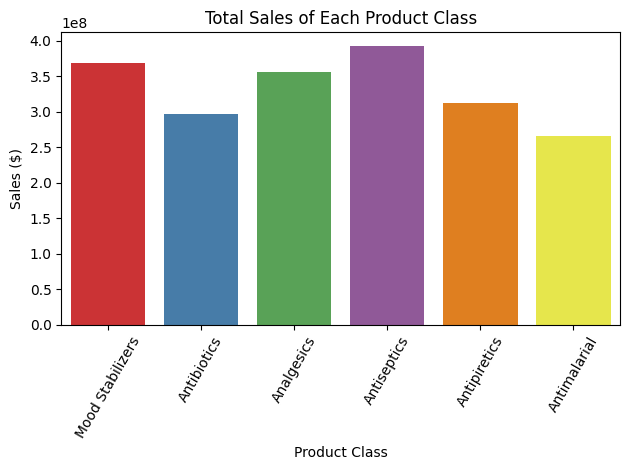

In [22]:
sns.barplot(x='Product Class', y='Sales', data=df, hue='Product Class', legend=False, errorbar=None, palette='Set1', estimator='sum')
plt.title('Total Sales of Each Product Class')
plt.xlabel('Product Class')
plt.xticks(rotation=(60))
plt.ylabel('Sales ($)')
plt.tight_layout()
#plt.savefig('Total Sales of Each Product Class.png')
plt.show()

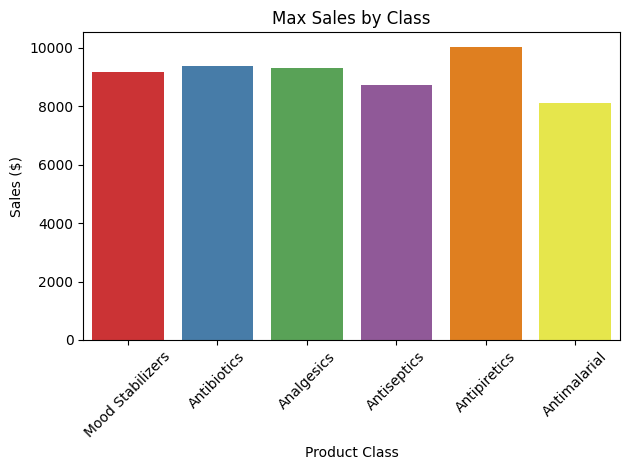

In [23]:
sns.barplot(x='Product Class', y='Sales', data=df, hue='Product Class', errorbar=None, palette='Set1', legend=False)
plt.title('Max Sales by Class')
plt.xlabel('Product Class')
plt.ylabel('Sales ($)')
plt.xticks(rotation=(45))
plt.tight_layout()
#plt.savefig('Max Sales by Product Class')
plt.show()

In [24]:
channel_sales = df.groupby(['Channel', 'Sub-channel'])['Sales'].agg(['mean', 'sum'])
channel_sales = channel_sales.rename(columns={'mean': 'Avg Sales ($)', 'sum': 'Total Sales ($)'})
channel_sales.sort_values(by='Total Sales ($)', ascending=False)          

,,Avg Sales ($),Total Sales ($)
Channel,Sub-channel,,
Pharmacy,Retail,9166.178672,5.376514e+08
Hospital,Government,9160.476669,5.173104e+08
Pharmacy,Institution,9174.652289,4.870364e+08
Hospital,Private,8871.635114,4.499161e+08


#### Year

In [25]:
yearly_sales = df.groupby(['Product Class', 'Year'])['Sales'].agg(['mean', 'sum'])
yearly_sales = yearly_sales.rename(columns={'mean': 'Avg Sales ($)', 'sum': 'Total Sales ($)'})
yearly_sales.sort_values(by='Total Sales ($)', ascending=False)

,,Avg Sales ($),Total Sales ($)
Product Class,Year,,
Antiseptics,2018,7709.377211,1.333568e+08
Mood Stabilizers,2018,8135.744298,1.248511e+08
Analgesics,2018,8263.385877,1.214635e+08
Antipiretics,2018,8769.288919,1.047755e+08
Antibiotics,2018,8233.763791,1.006001e+08
Antiseptics,2017,9657.826929,9.425073e+07
Antimalarial,2018,7131.778864,8.827003e+07
Mood Stabilizers,2017,10045.800940,8.760943e+07
Analgesics,2017,10373.603073,8.574820e+07


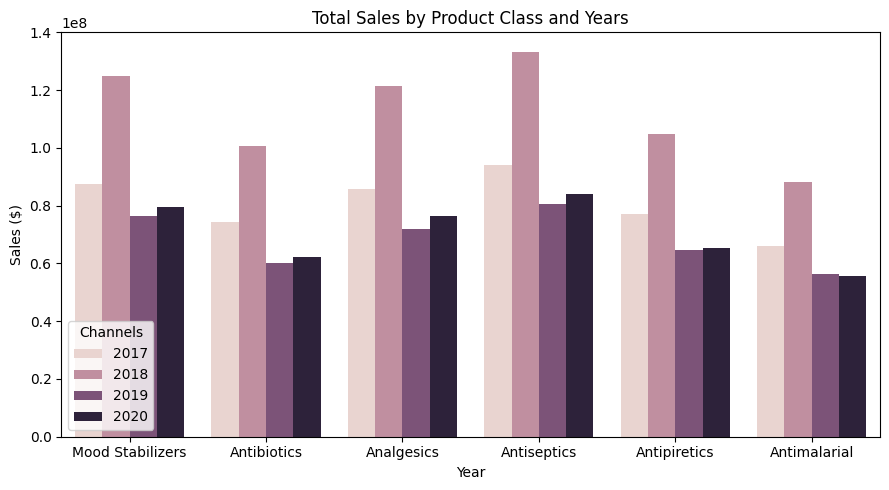

In [26]:
fig, ax = plt.subplots(figsize=(9, 5))
sns.barplot(x='Product Class', y='Sales', data=df, hue='Year', errorbar=None, estimator='sum')
plt.title('Total Sales by Product Class and Years')
plt.xlabel('Year')
plt.ylabel('Sales ($)')
plt.legend(title=('Channels'), loc='lower left')
#plt.savefig('Total Sales by Product Class and Years.png')
plt.tight_layout()
plt.show()

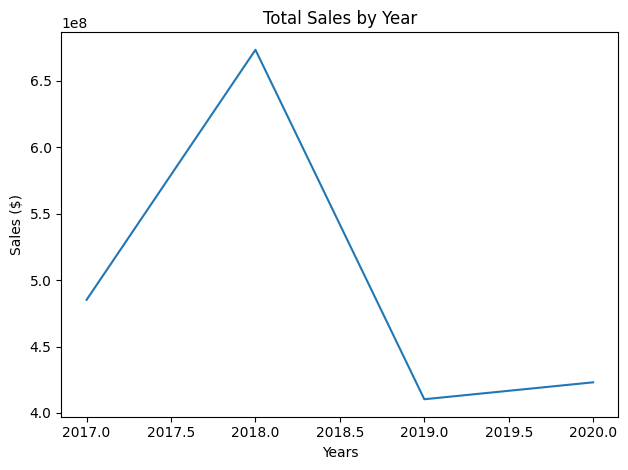

In [27]:
sns.lineplot(x='Year', y='Sales', data=df, errorbar=None, estimator='sum')
plt.title('Total Sales by Year')
plt.xlabel('Years')
plt.ylabel('Sales ($)')
#plt.savefig('Total Sales by Year.png')
plt.tight_layout()
plt.show()

#### Months

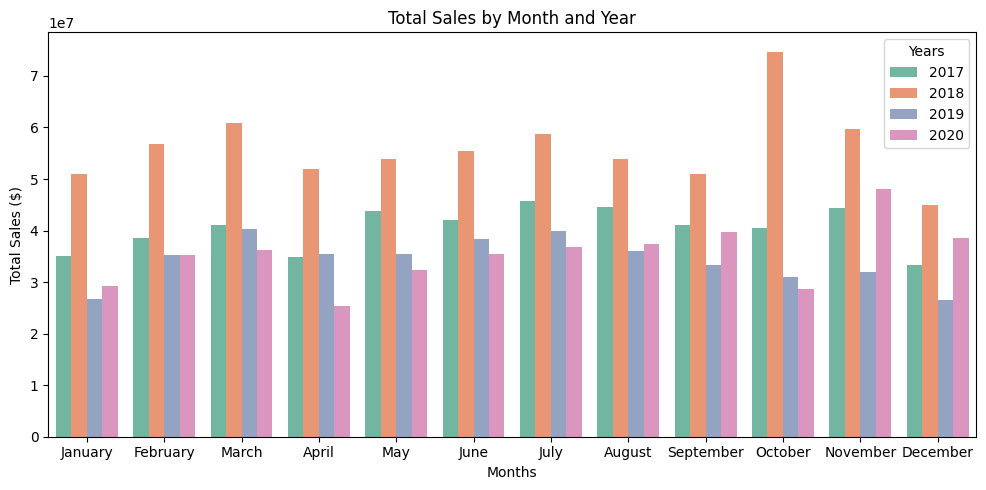

In [28]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x='Month', y='Sales', data=df, hue='Year', estimator='sum', palette='Set2', errorbar=None)
plt.title('Total Sales by Month and Year')
plt.xlabel('Months')
plt.ylabel('Total Sales ($)')
plt.legend(title='Years')
plt.tight_layout()
#plt.savefig('Total Sales by Month and Year.png')
plt.show()

### Distributors


#### Distributors by Country

In [29]:
distributor_sales = df.groupby(['Distributor', 'Country'])['Sales'].agg(['mean', 'sum'])
distributor_sales = distributor_sales.rename(columns={'mean': 'Avg Sales ($)', 'sum': 'Total Sales ($)'})
distributor_sales = distributor_sales.sort_values(by='Total Sales ($)', ascending=False)
distributor_sales

,,Avg Sales ($),Total Sales ($)
Distributor,Country,,
Gerlach LLC,Germany,8491.007864,8.491178e+08
Koss,Germany,10514.084425,5.029202e+08
Erdman,Germany,11802.443803,2.474028e+08
Stehr-Champlin,Poland,4710.221230,5.431356e+07
Kozey-Emmerich,Germany,14410.419391,3.879285e+07
Prohaska-Kuhic,Poland,6239.962128,3.624794e+07
Beier,Poland,13128.343634,3.526273e+07
Smith Inc,Poland,4773.669437,3.067560e+07
Welch-Langworth,Germany,12859.796075,3.014336e+07


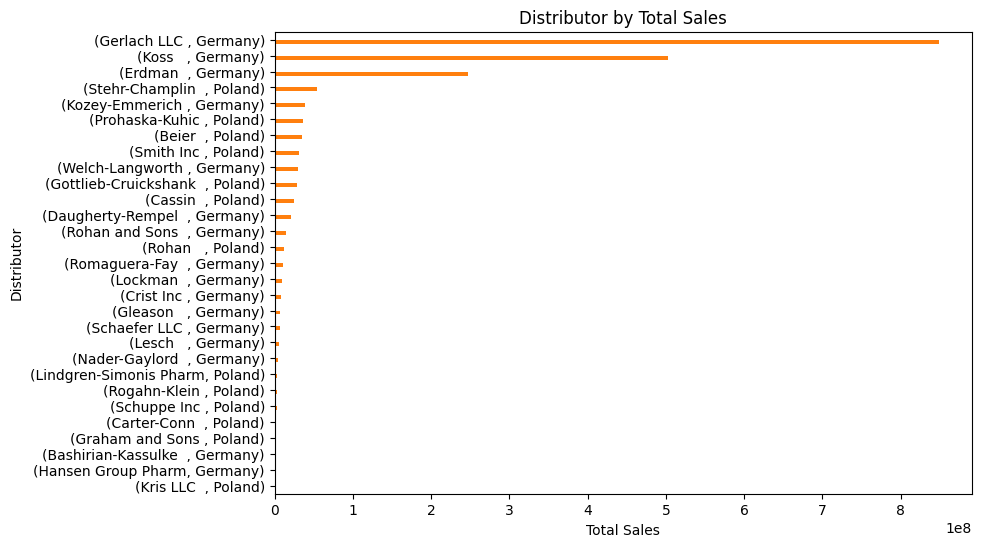

In [30]:
distributor_sales.plot(kind='barh', title=('Distributor by Total Sales'), xlabel='Total Sales', ylabel='Distributor', legend=False, figsize=(9, 6))
plt.gca().invert_yaxis()
#plt.savefig('Distributor by Total Sales.png')
plt.show()

#### Quantity

In [31]:
quantity_dist = df.groupby(['Distributor', 'Country'])['Quantity'].agg(['mean', 'sum']).round(0)
quantity_dist = quantity_dist.rename(columns={'mean': 'Avg Quantity', 'sum': 'Total Quantity'})
quantity_dist = quantity_dist.sort_values(by='Total Quantity', ascending=False)
quantity_dist

,,Avg Quantity,Total Quantity
Distributor,Country,,
Gerlach LLC,Germany,27.0,2703523.0
Koss,Germany,38.0,1813418.0
Erdman,Germany,43.0,906992.0
Kozey-Emmerich,Germany,63.0,168951.0
Stehr-Champlin,Poland,13.0,155126.0
Beier,Poland,45.0,120596.0
Welch-Langworth,Germany,50.0,117742.0
Prohaska-Kuhic,Poland,18.0,104827.0
Smith Inc,Poland,14.0,92905.0


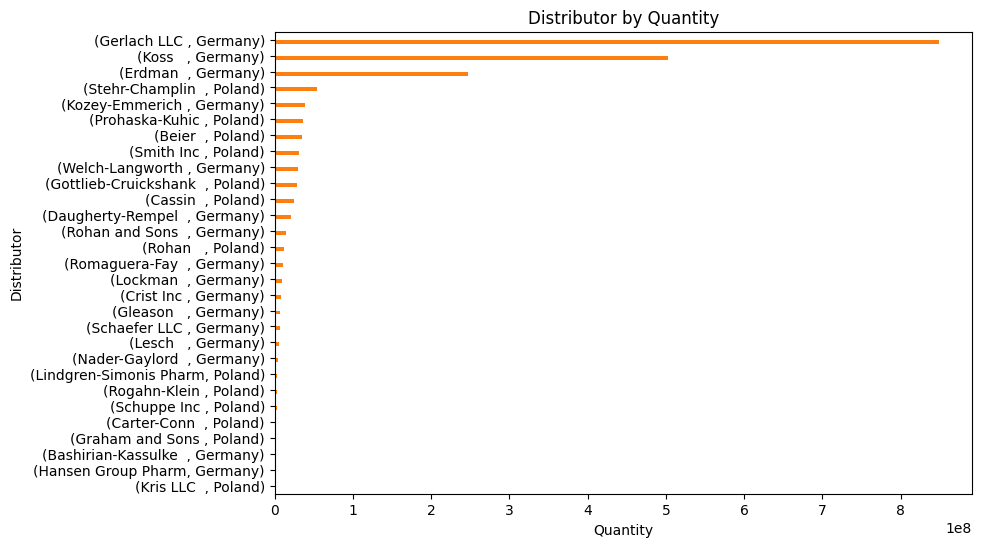

In [32]:
distributor_sales.plot(kind='barh', title=('Distributor by Quantity'), xlabel='Quantity', ylabel='Distributor', legend=False, figsize=(9, 6))
plt.gca().invert_yaxis()
#plt.savefig('Distributor by Quantity.png')

### Sales Teams

#### Sales Rep

In [33]:
sales_team = df.groupby(['Name of Sales Rep', 'Sales Team'])['Sales'].agg(['mean', 'sum']).round(0)
sales_team = sales_team.rename(columns={'mean': 'Avg Sales ($)', 'sum': 'Total Sales ($)'})
sales_team = sales_team.sort_values(by='Total Sales ($)', ascending=False)
sales_team

,,Avg Sales ($),Total Sales ($)
Name of Sales Rep,Sales Team,,
Jimmy Grey,Charlie,9217.0,155465421.0
Jessica Smith,Delta,9139.0,155020152.0
Erica Jones,Alfa,9225.0,154808221.0
Morris Garcia,Bravo,9205.0,153877724.0
Abigail Thompson,Bravo,9138.0,153860937.0
Alan Ray,Alfa,9091.0,153568656.0
Sheila Stones,Delta,9079.0,153162746.0
Steve Pepple,Bravo,9073.0,153089051.0
Anne Wu,Delta,9011.0,152309645.0


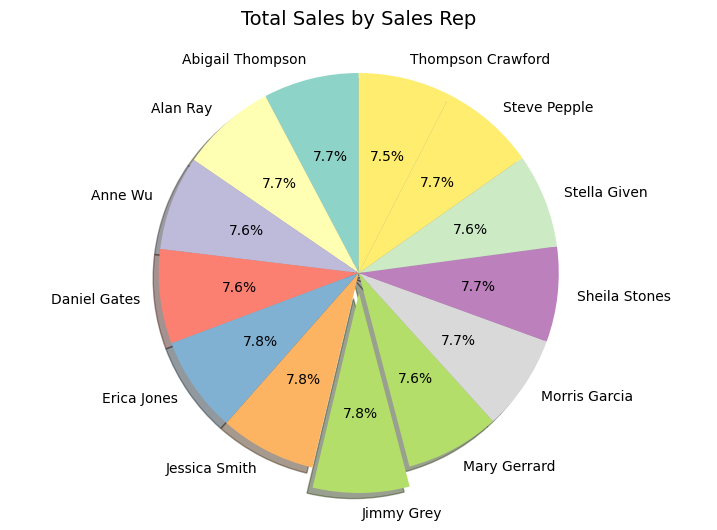

In [34]:
sales_rep = df.groupby('Name of Sales Rep')['Sales'].sum().reset_index()
plt.figure(figsize=(9, 6))
colors = plt.cm.Set3(np.linspace(0, 1, len(sales_team)))
explode = [0.1 if Name == 'Jimmy Grey' else 0 for Name in sales_rep['Name of Sales Rep']]
plt.pie(sales_rep['Sales'], labels=sales_rep['Name of Sales Rep'], autopct='%1.1f%%', explode=explode, shadow=True, startangle=90, colors=colors)
plt.title('Total Sales by Sales Rep', fontsize=14, pad=20)
plt.axis('equal')
#plt.savefig('Total Sales by Sales Rep.png')
plt.show()

#### Sales Team

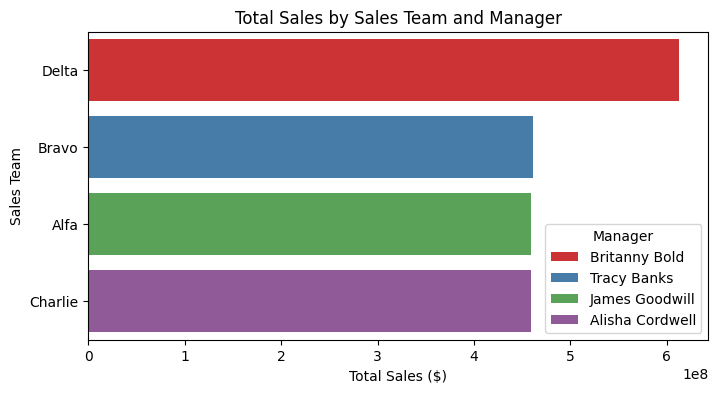

In [35]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x='Sales', y='Sales Team', data=df, hue='Manager', estimator='sum', errorbar=None, palette='Set1')
plt.title('Total Sales by Sales Team and Manager')
plt.xlabel('Total Sales ($)')
plt.ylabel('Sales Team')
#plt.savefig('Total Sales by Sales Team and Manager.png')
plt.show()

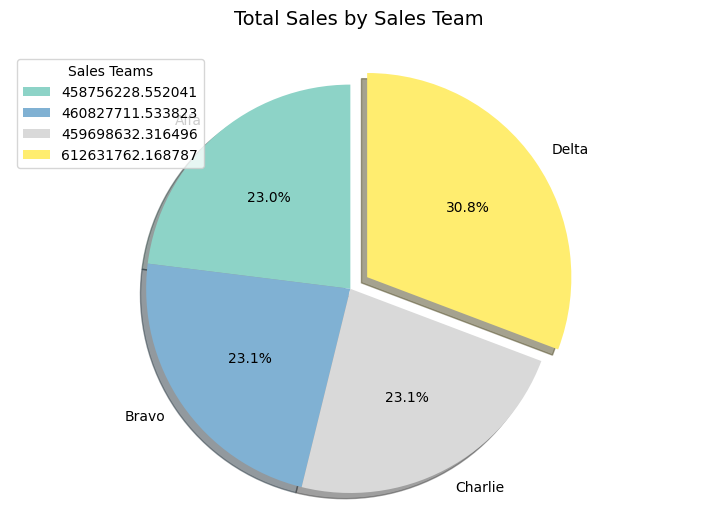

In [36]:
team_sales = df.groupby('Sales Team')['Sales'].sum().reset_index()
plt.figure(figsize=(9, 6))
colors = plt.cm.Set3(np.linspace(0, 1, len(team_sales)))
explode = [0.1 if team == 'Delta' else 0 for team in team_sales['Sales Team']]
plt.pie(team_sales['Sales'], labels=team_sales['Sales Team'], autopct='%1.1f%%', explode=explode, shadow=True, startangle=90, colors=colors)
plt.title('Total Sales by Sales Team', fontsize=14, pad=20)
plt.legend(team_sales['Sales'], title='Sales Teams', loc='best')
plt.axis('equal')
#plt.savefig('Total Sales by Sales team.png')
plt.show()

## ML Models for Predictions

### Preprocessing

In [37]:
df['Quantity_Price'] = df['Quantity'] * df['Price']
features = ['Distributor', 'City', 'Country', 'Channel', 'Sub-channel',
            'Product Name', 'Product Class', 'Quantity', 'Month', 
            'Year', 'Name of Sales Rep', 'Manager', 'Sales Team']
target_sales = 'Sales'
target_price = 'Price'

#### Label Encoding

In [38]:
categorical_columns = ['Distributor', 'Customer Name', 'City', 'Country', 'Channel', 
                      'Sub-channel', 'Product Name', 'Product Class', 
                      'Name of Sales Rep', 'Manager', 'Sales Team', 'Month']
for col in categorical_columns:
    df[col] = df[col].astype(str).str.strip()

In [39]:
label_encoders = {} 
encoded_data = []  
for col in categorical_columns:
    if col in df.columns:  
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str)) 
        label_encoders[col] = le  
        encoded_data.append(col)
        print(f"Encoded {col}: {df[col].nunique()} unique values")

Encoded Distributor: 29 unique values
Encoded Customer Name: 751 unique values
Encoded City: 749 unique values
Encoded Country: 2 unique values
Encoded Channel: 2 unique values
Encoded Sub-channel: 4 unique values
Encoded Product Name: 240 unique values
Encoded Product Class: 6 unique values
Encoded Name of Sales Rep: 13 unique values
Encoded Manager: 4 unique values
Encoded Sales Team: 4 unique values
Encoded Month: 12 unique values


#### Feature Scaling

In [40]:
numeric_columns = ['Quantity', 'Year']
scaled_data = []
for col in numeric_columns:
    if col in df.columns:
        scaler = StandardScaler()
        df[numeric_columns] = scaler.fit_transform(df[numeric_columns])
        scaled_data.append(col)
        print(f"Scaled {col}: {df[col].nunique()} unique values")

Scaled Quantity: 499 unique values
Scaled Year: 4 unique values


### Sales Model

#### Features Selection

In [41]:
features_for_sales = features + ['Price', 'Quantity_Price']
X_sales = df[features_for_sales]
y_sales = df[target_sales]
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_sales, y_sales, test_size=0.2, random_state=42)

#### Model Training

In [42]:
param_sales = {'learning_rate':0.1,
         'max_depth':5,
         'subsample':1.0,
         'colsample_bytree':1.0,
         'lambda':5.0,
         'alpha':0.5,
         'min_child_weight':5
         }
model_sales = xgb.XGBRegressor(objective='reg:squarederror', **param_sales, random_state=42, n_jobs=-1, n_estimators=100, enable_categorical=True)
model_sales.fit(X_train_s, y_train_s)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,1.0
,device,None
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,None


In [43]:
# Initialize Model Predictions for testing data
y_pred_s = model_sales.predict(X_test_s)

# Model Predictions for training Data
y_train_pred_s = model_sales.predict(X_train_s)

#### Model Evaluation

In [44]:
# Evaulation for Testing Data
mse_sales = mean_squared_error(y_test_s, y_pred_s)
rmse_sales = np.sqrt(mse_sales)
mae_sales = mean_absolute_error(y_test_s, y_pred_s)
r2_sales = r2_score(y_test_s, y_pred_s)
print('Model Evaluation Metrics for Sales Prediction (Testing Data):')
print(f"Mean Squared Error: {mse_sales:.2f}, RMSE: {rmse_sales:.2f}")
print(f"Mean Absolute Error: {mae_sales:.2f}")
print(f"R2 Score: {r2_sales:.2f}")

dmatrix_sales = xgb.DMatrix(X_train_s, label=y_train_s)
sales_cv = xgb.cv(param_sales, dtrain=dmatrix_sales, num_boost_round=100, nfold=5, metrics='rmse', early_stopping_rounds=10)
print("\nCross Validation Resuts for Sales Model:")
print(sales_cv.tail())

# Evaluaton for Training Data
mse_train_sales = mean_squared_error(y_train_s, y_train_pred_s)
rmse_train_sales = np.sqrt(mse_train_sales)
mae_train_sales = mean_absolute_error(y_train_s, y_train_pred_s)
r2_train_sales = r2_score(y_train_s, y_train_pred_s)
print('Model Evaluation Metrics for Sales Prediction (Training Data):')
print(f"\nMean Squared Error: {mse_train_sales:.2f}, RMSE: {rmse_train_sales:.2f}")
print(f"Mean Absolute Error: {mae_train_sales:.2f}")
print(f"R2 Score: {r2_train_sales:.2f}")

Model Evaluation Metrics for Sales Prediction (Testing Data):
Mean Squared Error: 9486.45, RMSE: 97.40
Mean Absolute Error: 46.58
R2 Score: 1.00

Cross Validation Resuts for Sales Model:
    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
95        99.073010        0.598024      101.209234       1.627515
96        98.868545        0.598998      101.036722       1.588280
97        98.770108        0.601522      100.946309       1.546351
98        98.549451        0.633928      100.761270       1.536726
99        98.236630        0.645569      100.526271       1.509237
Model Evaluation Metrics for Sales Prediction (Training Data):

Mean Squared Error: 9679.59, RMSE: 98.38
Mean Absolute Error: 47.15
R2 Score: 1.00


#### Visualization

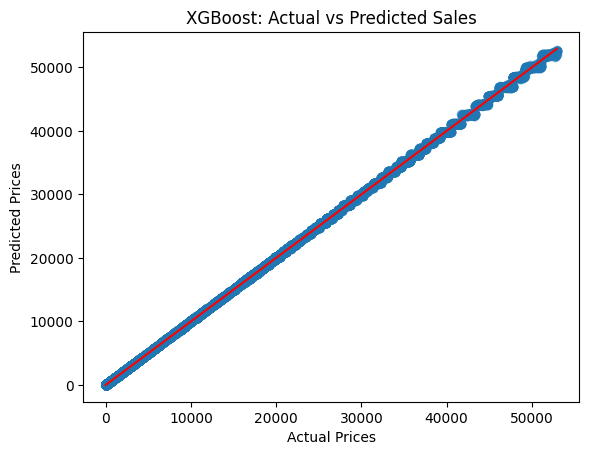

In [45]:
colors = ['red', 'green', 'blue', 'purple', 'orange']
plt.scatter(y_test_s, y_pred_s, alpha=0.5, label='Sales')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('XGBoost: Actual vs Predicted Sales')
plt.plot([min(y_test_s), max(y_test_s)], [min(y_test_s), max(y_test_s)], color='red')
plt.show()

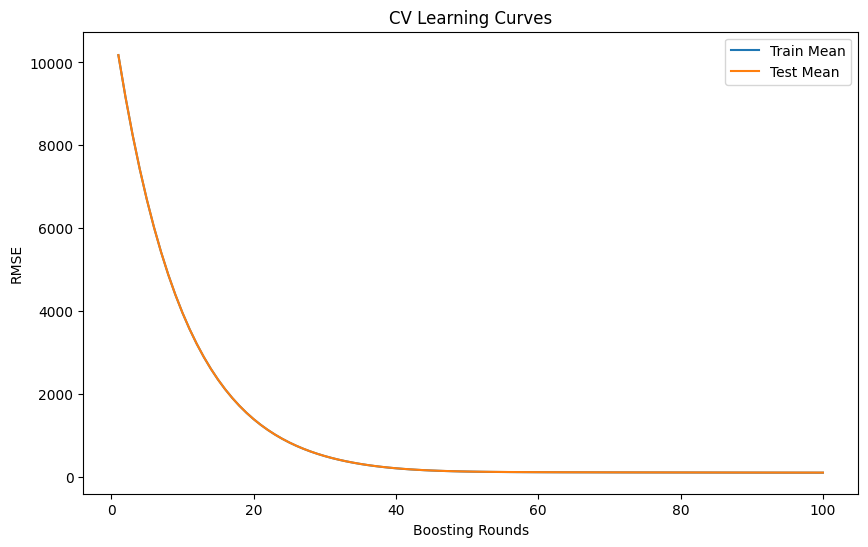

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(sales_cv.index + 1, sales_cv['train-rmse-mean'], label='Train Mean')
plt.plot(sales_cv.index + 1, sales_cv['test-rmse-mean'], label='Test Mean')
plt.fill_between(sales_cv.index + 1, 
                 sales_cv['train-rmse-mean'] - sales_cv['train-rmse-std'],
                 sales_cv['train-rmse-mean'] + sales_cv['train-rmse-std'], alpha=0.2)
plt.fill_between(sales_cv.index + 1, 
                 sales_cv['test-rmse-mean'] - sales_cv['test-rmse-std'],
                 sales_cv['test-rmse-mean'] + sales_cv['test-rmse-std'], alpha=0.2)
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.title('CV Learning Curves')
plt.legend()
plt.show()

#### Feature Importance

In [47]:
sales_importance_df = pd.DataFrame({
    'Feature': features_for_sales, 
    'Importance': model_sales.feature_importances_
}).sort_values(by='Importance', ascending=False).reset_index().drop('index', axis=1)
sales_importance_df = sales_importance_df[1:]
sales_importance_df

,Feature,Importance
1,Price,4.097116e-05
2,Product Name,3.684046e-05
3,Product Class,2.860275e-05
4,Quantity,2.506547e-05
5,Name of Sales Rep,1.787979e-05
6,Channel,1.539811e-05
7,Month,1.124738e-05
8,Sub-channel,9.877496e-06
9,Year,8.156077e-06
10,City,7.049584e-06


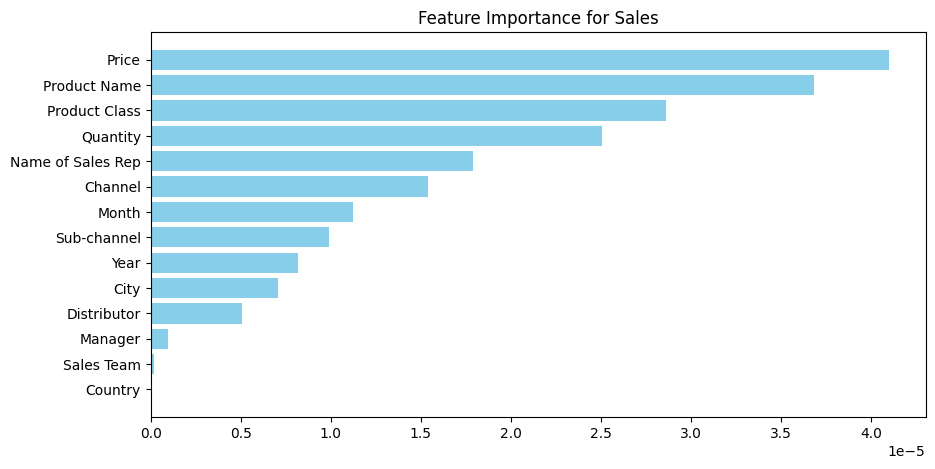

In [48]:
plt.figure(figsize=(10, 5))
plt.barh(sales_importance_df['Feature'], sales_importance_df['Importance'], color='skyblue')
plt.title('Feature Importance for Sales')
plt.gca().invert_yaxis()
plt.show()

<Axes: title={'center': 'XGBoost: Feature Importance (Sales)'}, xlabel='Importance score', ylabel='Features'>

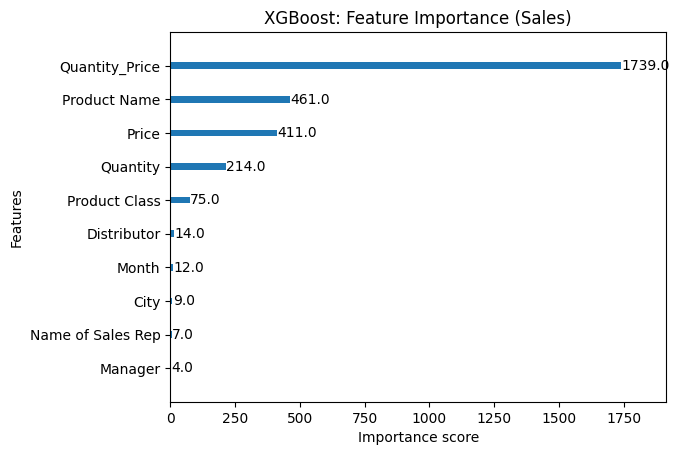

In [49]:
xgb.plot_importance(model_sales, max_num_features=10, title='XGBoost: Feature Importance (Sales)', grid=False)

### Price Model

#### Feature Selection

In [50]:
features_for_price = [f for f in features if f not in ['Quantity', 'Quantity_Price']]
X_price = df[features_for_price]
y_price = df[target_price]
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_price, y_price, test_size=0.2, random_state=42)

#### Model Training

In [51]:
param_price = {'learning_rate':0.5,
         'max_depth':9,
         'subsample':1.0,
         'colsample_bytree':1.0,
         'min_child_weight':1.0,
         'eta':0.05,
         'lambda':0.1,
         'alpha':0
}
model_price = xgb.XGBRegressor(objective='reg:squarederror', **param_price, n_estimators=300, random_state=42, enable_categorical=True)
model_price.fit(X_train_p, y_train_p)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,1.0
,device,None
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,None


In [52]:
# Initialize Model Prediction for Testing Data
y_pred_p = model_price.predict(X_test_p)

# Initialize Model Prediction for Training Data
y_train_pred_p = model_price.predict(X_train_p)

#### Model Evaluation

In [53]:
# Evaulation for Testing Data
mse_price = mean_squared_error(y_test_p, y_pred_p)
rmse_price = np.sqrt(mse_price)
mae_price = mean_absolute_error(y_test_p, y_pred_p)
r2_price = r2_score(y_test_p, y_pred_p)
print('Model Evaluation Metrics for Price Prediction (Testing Data):')
print(f"Mean Squared Error: {mse_price:.2f}, RMSE: {rmse_price:.2f}")
print(f"Mean Absolute Error: {mae_price:.2f}")
print(f"R2 Score: {r2_price:.2f}")

dmatrix_price = xgb.DMatrix(X_train_p, label=y_train_p)
price_cv = xgb.cv(param_price, dtrain=dmatrix_price, num_boost_round=100, nfold=5, metrics='rmse', early_stopping_rounds=10)
print("\nCross Validation Resuts for Price Model:")
print(price_cv.tail())

# Evaluaton for Training Data
mse_train_price = mean_squared_error(y_train_p, y_train_pred_p)
rmse_train_price = np.sqrt(mse_train_price)
mae_train_price = mean_absolute_error(y_train_p, y_train_pred_p)
r2_train_price = r2_score(y_train_p, y_train_pred_p)
print('Model Evaluation Metrics for Price Prediction (Training Data):')
print(f"\nMean Squared Error: {mse_train_price:.2f}, RMSE: {rmse_train_price:.2f}")
print(f"Mean Absolute Error: {mae_train_price:.2f}")
print(f"R2 Score: {r2_train_price:.2f}")

Model Evaluation Metrics for Price Prediction (Testing Data):
Mean Squared Error: 0.00, RMSE: 0.00
Mean Absolute Error: 0.00
R2 Score: 1.00

Cross Validation Resuts for Price Model:
    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
95         0.000352        0.000099        0.000352       0.000100
96         0.000320        0.000099        0.000320       0.000100
97         0.000285        0.000086        0.000286       0.000087
98         0.000260        0.000078        0.000261       0.000078
99         0.000239        0.000076        0.000239       0.000077
Model Evaluation Metrics for Price Prediction (Training Data):

Mean Squared Error: 0.00, RMSE: 0.00
Mean Absolute Error: 0.00
R2 Score: 1.00


#### Visualization

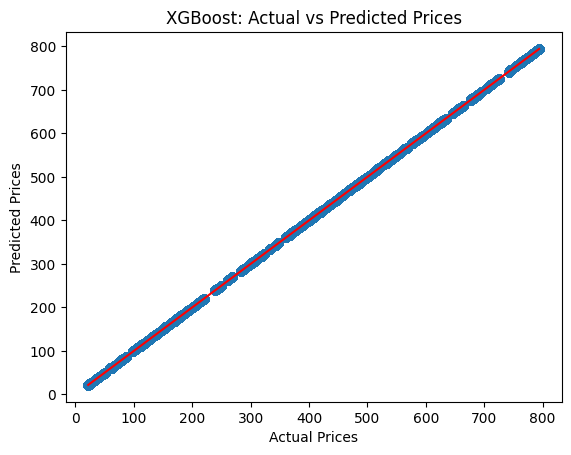

In [54]:
colors = ['red', 'green', 'blue', 'purple', 'orange']
plt.scatter(y_test_p, y_pred_p, alpha=0.5, label='Price')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('XGBoost: Actual vs Predicted Prices')
plt.plot([min(y_test_p), max(y_test_p)], [min(y_test_p), max(y_test_p)], color='red')
plt.show()

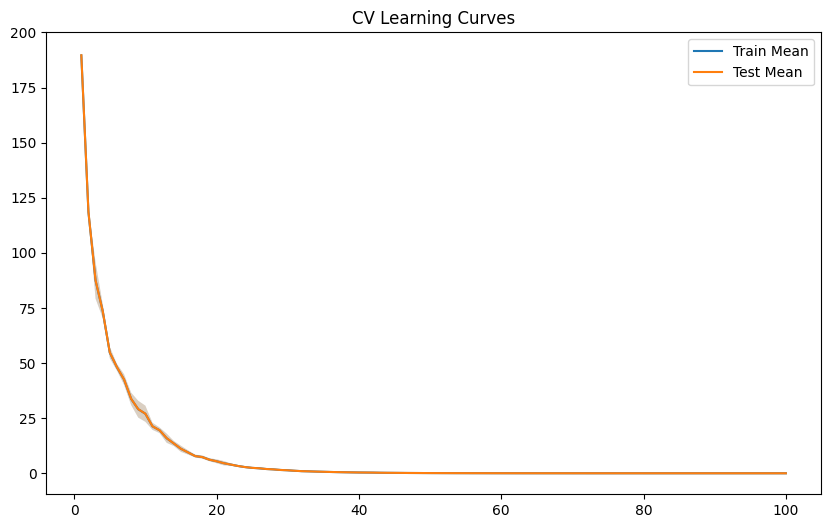

In [55]:
plt.figure(figsize=(10, 6))
plt.plot(price_cv.index + 1, price_cv['train-rmse-mean'], label='Train Mean')
plt.plot(price_cv.index + 1, price_cv['test-rmse-mean'], label='Test Mean')
plt.fill_between(price_cv.index + 1, 
                 price_cv['train-rmse-mean'] - price_cv['train-rmse-std'],
                 price_cv['train-rmse-mean'] + price_cv['train-rmse-std'], alpha=0.2)
plt.fill_between(price_cv.index + 1, 
                 price_cv['test-rmse-mean'] - price_cv['test-rmse-std'],
                 price_cv['test-rmse-mean'] + price_cv['test-rmse-std'], alpha=0.2)
plt.xlabel=('Boosting Rounds')
plt.ylabel=('RMSE')
plt.title('CV Learning Curves')
plt.legend()
plt.show()

#### Feature Importance

In [56]:
price_importance_df = pd.DataFrame({
    'Feature': X_train_p.columns, 
    'Importance': model_price.feature_importances_
}).sort_values(by='Importance', ascending=False).reset_index().drop('index', axis=1)
price_importance_df

,Feature,Importance
0,Product Class,0.644354
1,Product Name,0.355646
2,Distributor,0.000000
3,City,0.000000
4,Country,0.000000
5,Channel,0.000000
6,Sub-channel,0.000000
7,Month,0.000000
8,Year,0.000000
9,Name of Sales Rep,0.000000


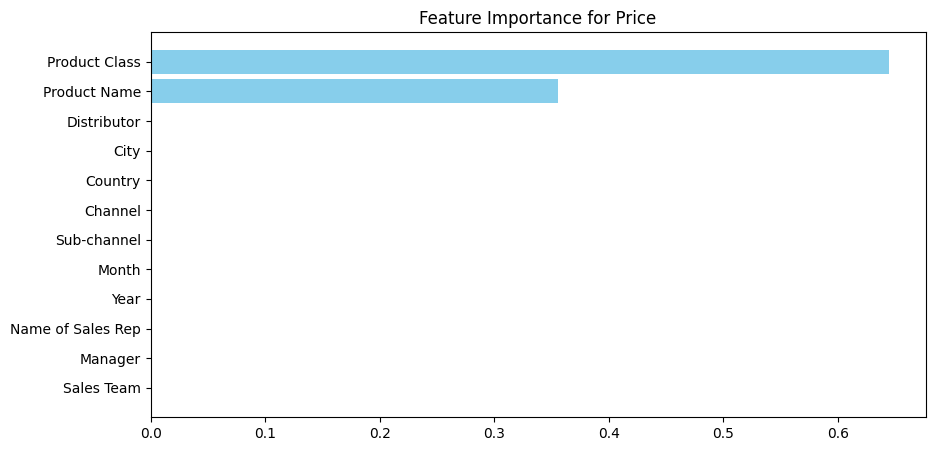

In [57]:
plt.figure(figsize=(10, 5))
plt.barh(price_importance_df['Feature'], price_importance_df['Importance'], color='skyblue')
plt.title('Feature Importance for Price')
plt.gca().invert_yaxis()
plt.show()

<Axes: title={'center': 'XGBoost: Feature Importance (Price)'}, xlabel='Importance score', ylabel='Features'>

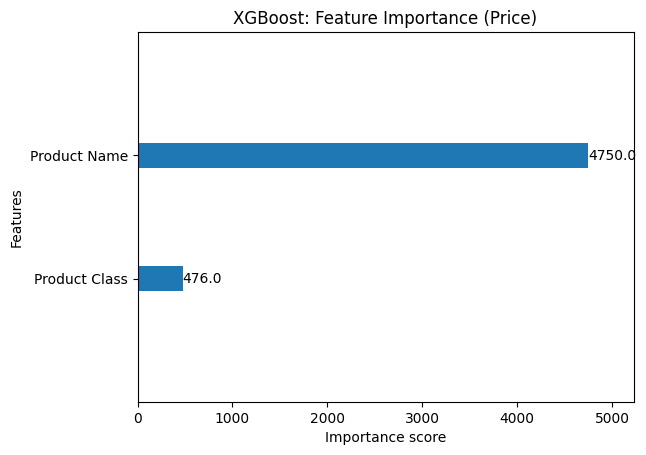

In [58]:
xgb.plot_importance(model_price, max_num_features=10, title='XGBoost: Feature Importance (Price)', grid=False)

### Predictions

In [62]:
def predict_new_data(new_data, model_sales, model_price, label_encoders, scaler, features_for_sales,
                     features_for_price, categorical_columns, numeric_columns):
    new_data_df = pd.DataFrame(new_data)
    # Encode categorical columns
    for col in categorical_columns:
        if col in new_data_df.columns:
            le = label_encoders[col]
            # Add 'Unknown' to classes if needed
            if 'Unknown' not in le.classes_:
                le.classes_ = np.append(le.classes_, 'Unknown')
            new_data_df[col] = new_data_df[col].apply(lambda x: x if x in le.classes_ else 'Unknown')
            new_data_df[col] = le.transform(new_data_df[col])
    
    # Scale numeric features
    input_data_as_array = np.asarray(new_data_df[numeric_columns])
    std_data = scaler.inverse_transform(input_data_as_array.reshape(1, -1)).flatten()
    new_data_df[numeric_columns] = std_data

    # Select only the columns used for training, in the correct order
    X_sales_pred = new_data_df.reindex(columns=features_for_sales, fill_value=0)
    X_price_pred = new_data_df.reindex(columns=features_for_price, fill_value=0)
    # Predict sales and price
    price_prediction = model_price.predict(X_price_pred)
    sales_prediction = price_prediction * new_data_df['Quantity']

    return sales_prediction, price_prediction


new_data_df = {
    'Distributor': ['Gottlieb-Cruickshank'],
    'Customer Name': ['Keeling LLC Pharmacy'],
    'City': ['Olsztyn'],
    'Country': ['Poland'],
    'Channel': ['Pharmacy'],
    'Sub-channel': ['Private'],
    'Product Name': ['Oxymotroban Fexoformin'],
    'Product Class': ['Analgesics'],
    'Quantity': [20.0],
  #  'Price': [368.0],
    #'Sales': [1472.0],
    'Month': ['January'],
    'Year': [2018],
    'Name of Sales Rep': ['Anne Wu'],
    'Manager': ['Britanny Bold'],
    'Sales Team': ['Delta']
#    'Quantity_Price': [1472.0]  
}
sales_prediction, price_prediction = predict_new_data(new_data_df, model_sales, model_price, label_encoders, scaler, features_for_sales, features_for_price, categorical_columns, numeric_columns)
results = pd.DataFrame({
    'Predicted Sales ($)': sales_prediction.round(2),
  #  'Actual Sales ($)': new_data_df['Sales'],
    'Predicted Price ($)': price_prediction.round(2),
  #  'Actual Price ($)': new_data_df['Price']
})
print("Predictions for New Data:")
for col in results.columns:
    results[col] = results[col].astype(int)
results

Predictions for New Data:


,Predicted Sales ($),Predicted Price ($)
0,9160,458


### Save Files

In [60]:
save_dir = 'model_artifacts'
os.makedirs(save_dir, exist_ok=True)
pipeline = {
    'features_for_sales': features_for_sales,
    'features_for_price': features_for_price,
    'label_encoders': label_encoders,
    'scaler': scaler, 
    'model_sales': model_sales,
    'model_price': model_price,
    'categorical_columns': categorical_columns,
    'numeric_columns': numeric_columns,
    'sales_importance_df': sales_importance_df,
    'price_importance_df': price_importance_df
}
joblib.dump(pipeline, os.path.join(save_dir, 'pipeline.joblib'))
print(f"All components saved to '{save_dir}' directory")

All components saved to 'model_artifacts' directory


### Readme

In [61]:
with open ('Readme.md', 'w') as f:
    f.write("""
# Prediction and Dashboard for Pharma Sales and Price.
**Objective**: This Project focuses on the prediction of Pharma Sales and Price as well as a detailed Dashboard Analysis.

## Table of Contents
- [Data Overview](#data-overview)
- [Data Cleaning](#data-cleaning)
- [Exploratory Data Analysis (EDA)](#exploratory-data-analysis-eda)
- [Machine Learning Models](#machine-learning-models)
- [Data Preprocessing](#data-preprocessing)
- [Feature Engineering](#feature-engineering)
- [Model Training & Evaluation](#model-training--evaluation)
- [Feature Importance](#feature-importance)
- [Predictions on New Data](#predictions-on-new-data)
- [Model Artifacts](#model-artifacts)
- [Dashboard Creation](#dashboard-creation)
- [Conclusion](#conclusion)
        
## Data Overview
    The dataset contains sales records from a pharmaceutical company, including details about products, distributors, sales representatives, sales and price figures.
The original dataset has 254,083 rows and 18 columns. After cleaning, it has 218,928 and 18 columns. The cleaned dataset is further used for analysis, modeling, and 
also used in the creation of a dashboard report PowerBI.
The cleaned dataset is saved as 'cleaned_pharma_data.csv', and the original dataset is 'pharma-data.csv'. 
**Columns**:
- Distributor
- Customer Name
- City
- Country
- Channel
- Sub-channel
- Product Name
- Product Class
- Quantity
- Price
- Sales
- Month
- Year
- Name of Sales Rep
- Manager
- Sales Team
- Quantity_Price (Engineered Feature)
        
## Data Cleaning
The data cleaning process involved:
- Handling errors in 'Quantity' and 'Sales' columns by converting to absolute values.
- Fixing data type error by converting 'Quantity', 'Sales', and 'Price' columns to numeric types.
- Removing duplicates (there were 4 duplicates).
- Identifying and removing outliers in 'Sales' and 'Quantity' columns using the IQR method.
- Final cleaned dataset has 218,928 rows and 18 columns.
        
## Exploratory Data Analysis (EDA)
EDA was performed to understand the data distribution and relationships:
- Descriptive statistics were generated for numerical columns.
- Correlation analysis showed strong correlation between 'Sales' and 'Price'. However, 'Quantity' had the strongest correlation with 'Sales'.
- Visualizations included bar plots, pie charts, and line plots to analyze sales by product name and class, channel, year, month, distributor, and sales rep and team.
- Further analysis was done to understand the quantity sold by distributors.
- Key insights were drawn from the visualizations to inform feature selection and engineering.
Visuals created during EDA were saved as PNG files and are saved in the "visual outputs" directory.
        
## Machine Learning Models
Two separate XGBoost regression models were developed:
1. **Price Prediction Model**: Predicts the price of pharmaceutical products based on various features but excluding 'Quanity', 'Quantity_Price', and 'Sales'.
2. **Sales Prediction Model**: Predicts sales figures using all relevant features including 'Quantity', 'Price' and 'Quantity_Price'.
Both models were trained and evaluated using metrics such as RMSE, MAE, and R2 Score.
        
## Data Preprocessing
Data preprocessing steps included:
- Encoding categorical variables using Label Encoding.
- Scaling numerical features ('Quantity' and 'Year') using StandardScaler. Taget variables ('Price' and 'Sales') were not scaled.
- Splitting the data into training and testing sets (80-20 split). The random state was set to 42 for better results.
        
## Feature Engineering
Although by default 'Sales' is as a result of multiplying 'Price' by 'Quantity', an additional feature 'Quantity_Price' was created by multiplying 'Quantity' and 'Price'.
This feature was used in the Sales Prediction Model to improve the accuracy of the sales model and predictions.
        
## Model Training & Evaluation
Both models were trained using the XGBoost regressor with hyperparameters optimized through cross-validation.
The models were evaluated on the test set using:
- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)
- Mean Absolute Error (MAE)
- R2 Score
- Cross-validation results were also analyzed to ensure model robustness and inspect for overfitting or underfitting.
The Sales model suffered from overfitting while the price model had slight underfitting. Hyperparameters were adjusted to mitigate these issues.
After the hyperparameter tuning, the models were able to generalize well on unseen data and the issues of overfitting and underfitting were resolved.
However, the sales model still has errors (MSE, MAE) due to the complexity of sales data.
The evaluations metrics for both models are summarized below:
- **Price Model**:
- mse_price = {mse_price:.2f}
- rmse_price = {rmse_price:.2f}
- mae_sales = {mae_price:.2f}
- r2_sales = {r2_price:.2f}
- Cross-validation for price model:
cv_price = {cv_price}
- **Sales Model**:
- mse_sales = {mse_sales:.2f}   
- rmse_sales = {rmse_sales:.2f} 
- mae_sales = {mae_sales:.2f}
- r2_sales = {r2_sales:.2f}
- Cross-validation for sales model:
cv_sales = {cv_sales}
        
## Feature Importance
Feature importance was analyzed for both models to understand which features had the most impact on predictions.
- For the Price Model, 'Product Name' and 'Product Class' were the most important features.
- For the Sales Model, 'Price', 'Quantity', 'Product Class' and 'Product Name' were the top features.
Visualizations of feature importance were created to aid interpretation.

## Predictions on New Data
The trained models were used to make predictions on existing data points and also on new data points. 
Due to the complexity of sales data, the sales model had some errors in predictions so the price model was used to predict price and then the results for sales was 
calculated by multiplying the predicted price by the quantity.
An example of existing data used for predictions:
- Distributor: 'Gottlieb-Cruickshank'
- Customer Name: 'Keeling LLC Pharmacy'
- City: 'Olsztyn'
- Country: 'Poland'
- Channel: 'Pharmacy'
- Sub-channel: 'Private'
- Product Name: 'Oxymotroban Fexoformin'
- Product Class: 'Analgesics'
- Quantity: 20.0
- Month: 'January'
- Year: 2018
- Name of Sales Rep: 'Anne Wu'
- Manager: 'Britanny Bold'
- Sales Team: 'Delta'
    The predicted results were:
- Predicted Sales ($): 9160
- Predicted Price ($): 458
The results were rounded to the nearesr integer for simplicity and they were exactly the same as the actual values.
        
## Model Artifacts
All components of the pipeline were saved using joblib for future use. This includes:
- Trained models (Sales and Price)
- Label encoders for categorical variables
- StandardScaler for numerical features
- Feature lists for both models
- Feature importance dataframes for both models.
The artifacts are saved in the 'model_artifacts' directory.
        
## Dashboard Creation
A dashboard was created using PowerBI to visualize key insights from the data. The dashboard includes:
- Sales by Product Class
- Sales by Channel and Sub-channel
- Sales by Year and Month
- Sales by Distributor and Country
- Sales by Sales Rep and Sales Team
The dashboard provides an interactive way to explore the data and understand sales trends.
The cleaned dataset 'cleaned_pharma_data.csv' was used as the data source for the dashboard.
The PowerBI dashboard file is saved as 'Pharma Sales Dashboard.pbix'.
        
## Conclusion
This project successfully demonstrated the end-to-end process of data cleaning, exploratory data analysis, feature engineering, model training and evaluation, 
and dashboard creation for pharmaceutical sales data. 
The developed models can be used for predicting sales and prices, and the dashboard provides valuable insights for decision-making.

**Note**: The models, while effective, may still have limitations due to the inherent complexity and variability in sales data.
        
**Connect with me**:
- [LinkedIn](https://www.linkedin.com/in/ireoluwawolemi-akindipe-16b711373?utm_source=share&utm_campaign=share_via&utm_content=profile&utm_medium=android_app)
- [GitHub](https://github.com/Dhela456)

""".format(mse_price=mse_price, rmse_price=rmse_price, mae_price=mae_price, r2_price=r2_price, cv_price=price_cv.tail() if 'price_cv' in locals() else 'N/A',
           mse_sales=mse_sales, rmse_sales=rmse_sales, mae_sales=mae_sales, r2_sales=r2_sales, cv_sales=sales_cv.tail() if 'price_cv' in locals() else 'N/A'))